In [3]:
import pandas as pd
import geopandas as gpd
from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore")

name = '01-03'

stay_points_path=f'result/stay_points/stay_points_{name}.csv'
# polygons_path='result/clusters/cl_tmp.feather'
polygons_path='result/clusters/cl_01-03.feather'
output_path='result/od/od_table.csv'

# 1. 读取停靠点数据
df = pd.read_csv(stay_points_path)
df['timestamp'] = pd.to_datetime(df['timestamp'], format='mixed', errors='coerce')
df['timestamp_off'] = pd.to_datetime(df['timestamp_off'], format='mixed', errors='coerce')

# 2. 读取港口多边形数据
polygons_gdf = gpd.read_feather(polygons_path)

# 3. 将停靠点转为 GeoDataFrame（需要指定坐标系，假设为 WGS84）
gdf = gpd.GeoDataFrame(
    df,
    geometry=gpd.points_from_xy(df['longitude'], df['latitude']),
    crs="EPSG:4326"
)

# 4. 空间连接：将每个停靠点映射到其所在的多边形 label
#   predicate='within' 表示点在多边形内部
joined_gdf = gpd.sjoin(gdf, polygons_gdf, how='left', predicate='within')
joined_gdf = joined_gdf[joined_gdf['label'].notna()]
joined_gdf['label'] = joined_gdf['label'].astype(int)

# 为避免冲突，将 polygons_gdf 中的 'label' 列重命名
joined_gdf.rename(columns={'label': 'port_label'}, inplace=True)

# 5. 对结果按 mmsi、timestamp 排序，便于构造连续 OD
joined_gdf.sort_values(by=['mmsi', 'timestamp'], inplace=True)
joined_gdf.reset_index(drop=True, inplace=True)

# 6. 按 mmsi 分组，构造 OD
od_records = []
grouped = joined_gdf.groupby('mmsi', group_keys=True)

# 使用 tqdm 显示分组进度
for mmsi, group in tqdm(grouped, total=grouped.ngroups):
    group = group.sort_values('timestamp').reset_index(drop=True)
    
    # 逐对取相邻记录
    for i in range(len(group) - 1):
        O = group.loc[i]
        D = group.loc[i + 1]
        
        # 只记录 label 不同的 OD（即不同的港口多边形）
        if O['port_label'] != D['port_label'] and O['timestamp_off'] < D['timestamp']:
            od_records.append({
                'mmsi': mmsi,
                'O_label': O['port_label'],
                'O_latitude': O['latitude'],
                'O_longitude': O['longitude'],
                'O_timestamp': O['timestamp_off'],       # 使用 timestamp_off
                'D_label': D['port_label'],
                'D_latitude': D['latitude'],
                'D_longitude': D['longitude'],
                'D_timestamp': D['timestamp']            # 使用下一条 timestamp
            })

# 7. 生成 OD 表并保存
od_df = pd.DataFrame(od_records)
od_df.to_csv(output_path, index=False)
print(f"OD 表已保存到: {output_path}")

100%|██████████| 27965/27965 [01:47<00:00, 260.53it/s] 


OD 表已保存到: result/od/od_table.csv


In [2]:
import pandas as pd
import geopandas as gpd

date = pd.to_datetime('2022-02-24')
day = 30

# 1. 读取之前生成的 OD 表
od_df = pd.read_csv('result/od/od_table.csv')

od_df['O_timestamp'] = pd.to_datetime(od_df['O_timestamp'], errors='coerce')
od_df['D_timestamp'] = pd.to_datetime(od_df['D_timestamp'], errors='coerce')

if day > 0:
    start_date = date
    end_date = date + pd.Timedelta(days=day)
else:
    start_date = date + pd.Timedelta(days=day)
    end_date = date
od_df = (od_df[(od_df['O_timestamp'] >= start_date) & (od_df['D_timestamp'] < end_date)])

# 2. 聚合 OD 表：按 O_label 和 D_label 分组，统计每组的船舶数
agg_df = od_df.groupby(['O_label', 'D_label'], as_index=False).agg({'mmsi': 'count'})
agg_df.rename(columns={'mmsi': 'count'}, inplace=True)


# 3. 读取多边形数据，wp_tmp.feather，内含每个聚类的多边形和其他属性
polygons_gdf = gpd.read_feather(f'result/clusters/cl_{name}.feather')

# 4. 计算每个多边形的质心，并提取质心的经纬度
polygons_gdf['centroid'] = polygons_gdf.geometry.centroid
polygons_gdf['centroid_lat'] = polygons_gdf.centroid.y
polygons_gdf['centroid_lon'] = polygons_gdf.centroid.x

# 5. 创建映射：以 label 为键，质心坐标为值
label_to_centroid = polygons_gdf.set_index('label')[['centroid_lat', 'centroid_lon']]

# 6. 将质心信息合并到聚合的 OD 表中
# 合并 O_label 的质心
agg_df = agg_df.merge(label_to_centroid, left_on='O_label', right_index=True, how='left')
agg_df.rename(columns={'centroid_lat': 'O_latitude', 'centroid_lon': 'O_longitude'}, inplace=True)

# 合并 D_label 的质心，使用不同的后缀
agg_df = agg_df.merge(label_to_centroid, left_on='D_label', right_index=True, how='left', suffixes=('', '_D'))
agg_df.rename(columns={'centroid_lat': 'D_latitude', 'centroid_lon': 'D_longitude'}, inplace=True)

# 7. 调整输出列顺序（不需要时间字段）
agg_df = agg_df[['O_label', 'O_latitude', 'O_longitude', 'D_label', 'D_latitude', 'D_longitude', 'count']]

# 8. 保存结果到 CSV 文件
output_csv = 'result/od/od_aggregated.csv'
agg_df.to_csv(output_csv, index=False)
print(f"OD 聚合结果已保存到: {output_csv}")

OD 聚合结果已保存到: result/od/od_aggregated.csv


In [4]:
import pandas as pd
from tqdm import tqdm

# 设定日期和时间范围
date = pd.to_datetime('2022-02-24')
day_range = range(-30, 0)

# 1. 读取之前生成的 OD 表
od_df = pd.read_csv('result/od/od_table.csv')

# 转换时间戳为 datetime 类型
od_df['O_timestamp'] = pd.to_datetime(od_df['O_timestamp'], errors='coerce')
od_df['D_timestamp'] = pd.to_datetime(od_df['D_timestamp'], errors='coerce')

# 2. 初始化一个空的列表用于存储转换后的动态图数据
graph_records = []

# 3. 遍历 day_range 来处理每一天
for day in tqdm(day_range, desc="Processing days"):
    # 计算当前时间（以0点为准）
    current_time = date + pd.Timedelta(days=day)
    
    # 4. 按条件筛选：O_timestamp <= current_time <= D_timestamp
    valid_od_df = od_df[(od_df['O_timestamp'] <= current_time) & (od_df['D_timestamp'] >= current_time)]
    
    # 5. 聚合每个 (source, target, time) 的记录，计算 weight
    for _, group in valid_od_df.groupby(['O_label', 'D_label']):
        # 每个 (source, target) 组合对应的时间和权重
        group_time = current_time
        weight = len(group)
        
        # 6. 记录到图数据中
        graph_records.append({
            'source': group.iloc[0]['O_label'],
            'target': group.iloc[0]['D_label'],
            'weight': weight,
            'time': day - min(day_range)
        })

# 7. 将所有记录转换为 DataFrame，并根据 time, source, target 字段升序排序
graph_df = pd.DataFrame(graph_records)
graph_df = graph_df.sort_values(by=['time', 'source', 'target'])

# 8. 将结果保存到 CSV 文件
graph_df.to_csv('result/od/dynamic_graph.csv', index=False)
print("动态图已保存到: result/od/dynamic_graph.csv")


Processing days: 100%|██████████| 30/30 [00:08<00:00,  3.34it/s]

动态图已保存到: result/od/dynamic_graph.csv


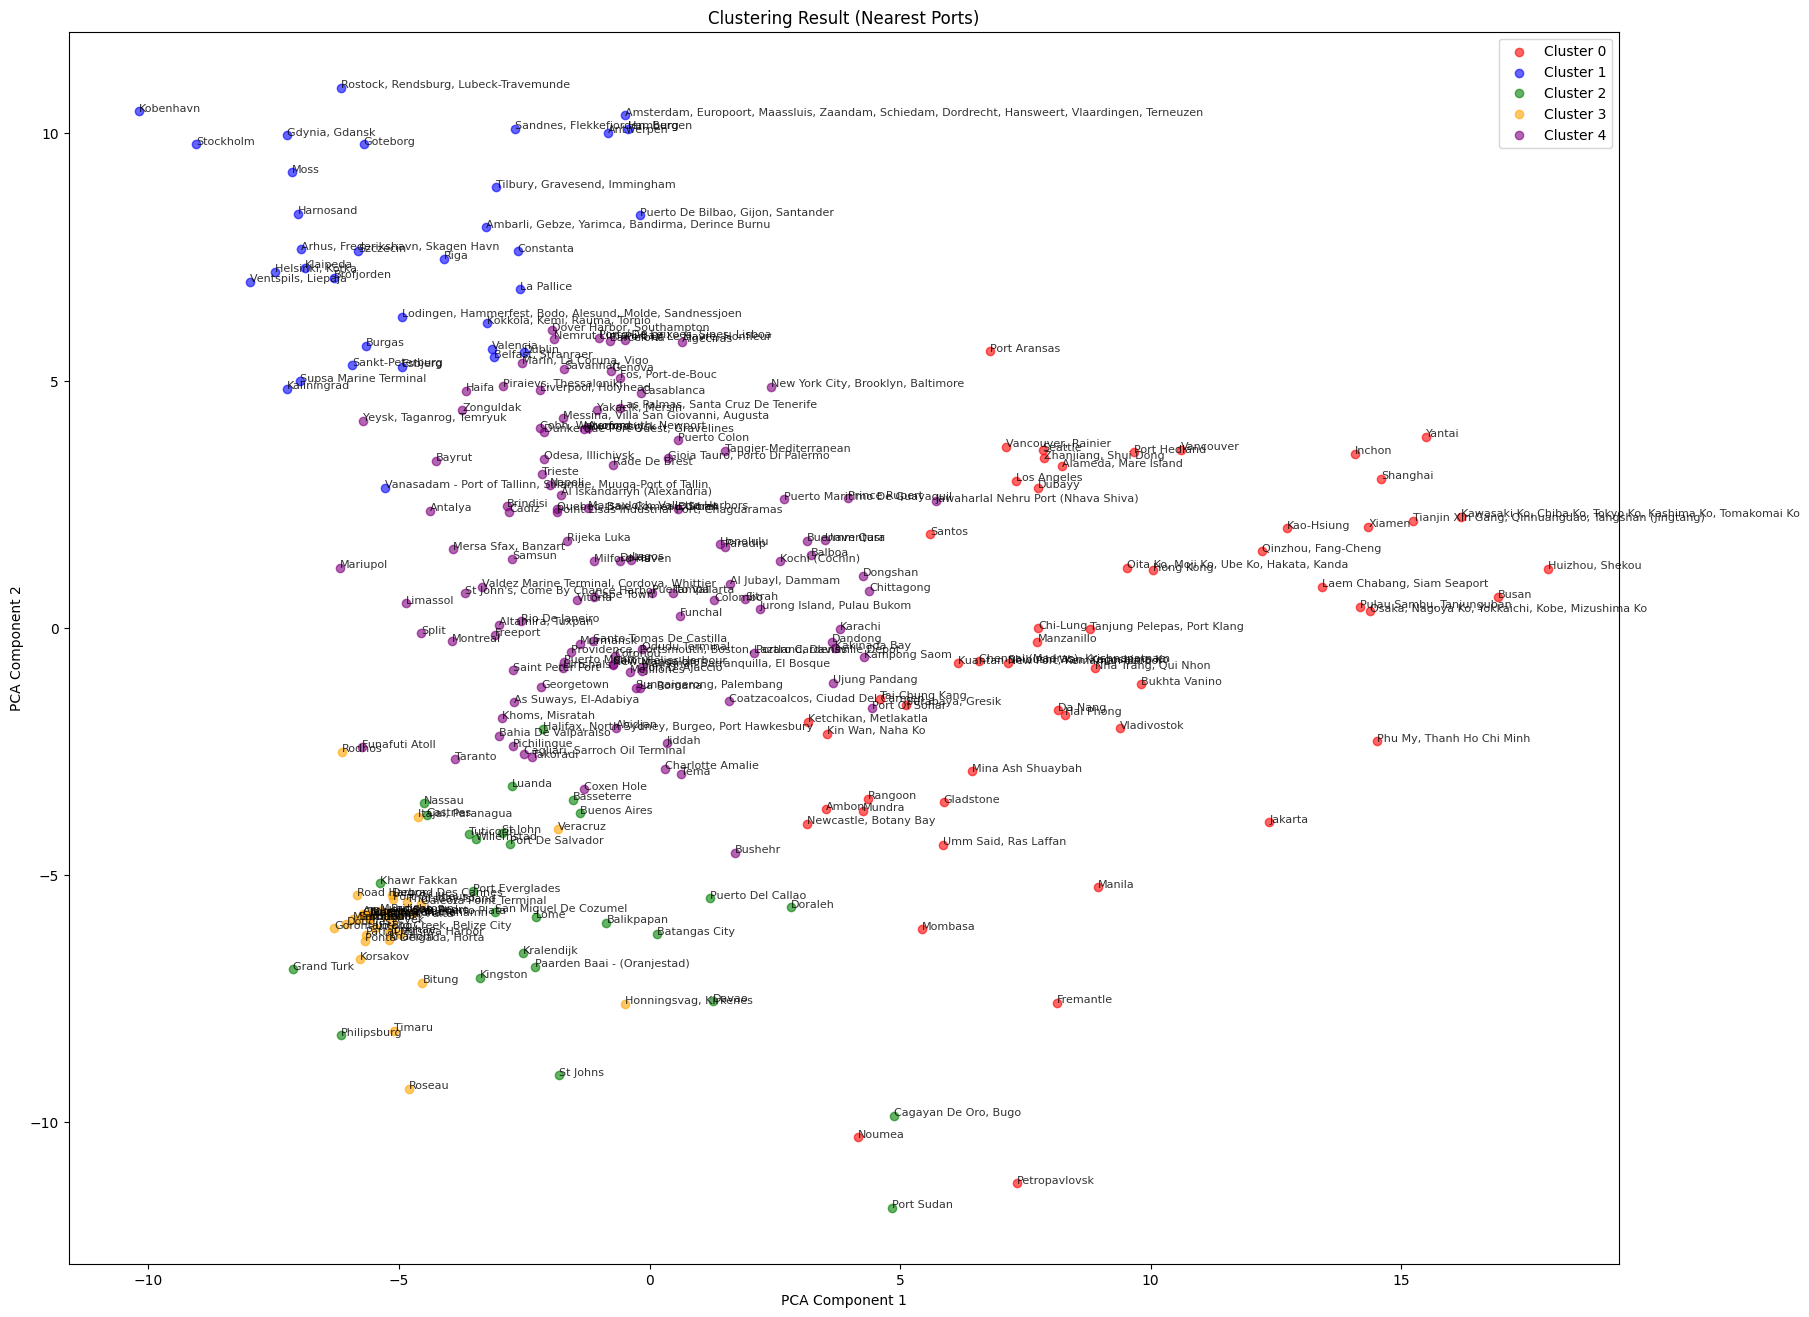

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import geopandas as gpd
from shapely.geometry import Point
from sklearn.preprocessing import StandardScaler

# 1. 加载节点的地理信息
clusters = pd.read_feather('result/clusters/cl_01-03.feather')

# 2. 加载节点嵌入数据
node_embeddings = pd.read_csv('result/od/nodeembs_epoch98_+30.csv', header=None)
node_embeddings = node_embeddings.values[:, 1:]  # 将数据转换为NumPy数组，并去除第一列（第一列是标签，不参与拟合）

if node_embeddings.shape[0] < clusters.shape[0]: # 如果节点嵌入数据的行数不足 clusters 的行数，则补充缺失的部分
    n_needed = clusters.shape[0] - node_embeddings.shape[0]
    # 获取嵌入向量的维度
    d = node_embeddings.shape[1]
    # 生成随机向量（服从标准正态分布），并对每一行归一化，使其模长为1
    random_vectors = np.random.randn(n_needed, d)
    norms = np.linalg.norm(random_vectors, axis=1, keepdims=True)
    random_vectors = random_vectors / norms
    # 将生成的随机向量追加到原有的 node_embeddings 后面
    node_embeddings = np.vstack([node_embeddings, random_vectors])

# 3. 对节点嵌入进行标准化
scaler = StandardScaler()
node_embeddings_scaled = scaler.fit_transform(node_embeddings)

# 4. 使用KMeans对节点嵌入进行聚类
kmeans = KMeans(n_clusters=5, random_state=0)  # 假设聚成5个簇
clusters['cluster'] = kmeans.fit_predict(node_embeddings_scaled)

# 5. 进行PCA降维，以便进行可视化
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(node_embeddings_scaled)

# 6. 将PCA降维结果添加到clusters数据框中
clusters['pca_x'] = reduced_embeddings[:, 0]
clusters['pca_y'] = reduced_embeddings[:, 1]

# 7. 绘制聚类结果
plt.figure(figsize=(20, 16))
# 定义颜色，可以根据聚类数调整颜色列表
colors = ['red', 'blue', 'green', 'orange', 'purple']

# 遍历每个聚类类别
for cl in sorted(clusters['cluster'].unique()):
    sub_df = clusters[clusters['cluster'] == cl]
    plt.scatter(sub_df['pca_x'], sub_df['pca_y'], 
                color=colors[cl % len(colors)], 
                label=f'Cluster {cl}', alpha=0.6)
    # 对每个点添加 nearest_ports 标签
    for idx, row in sub_df.iterrows():
        plt.annotate(row['nearest_ports'], (row['pca_x'], row['pca_y']), fontsize=8, alpha=0.8)

plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('Clustering Result (Nearest Ports)')
plt.legend()
plt.show()
